In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns

# Distribution of No of Employees

In [51]:
num_employees = pd.read_excel("../data/Financial/number of employees.xls", sheet_name = "Results")

WARNING *** file size (4723798) not 512 + multiple of sector size (512)


## There is a significant peak at 500 !! How to interpret it. Is RDD valid anymore

Text(0,0.5,'No. of Companies')

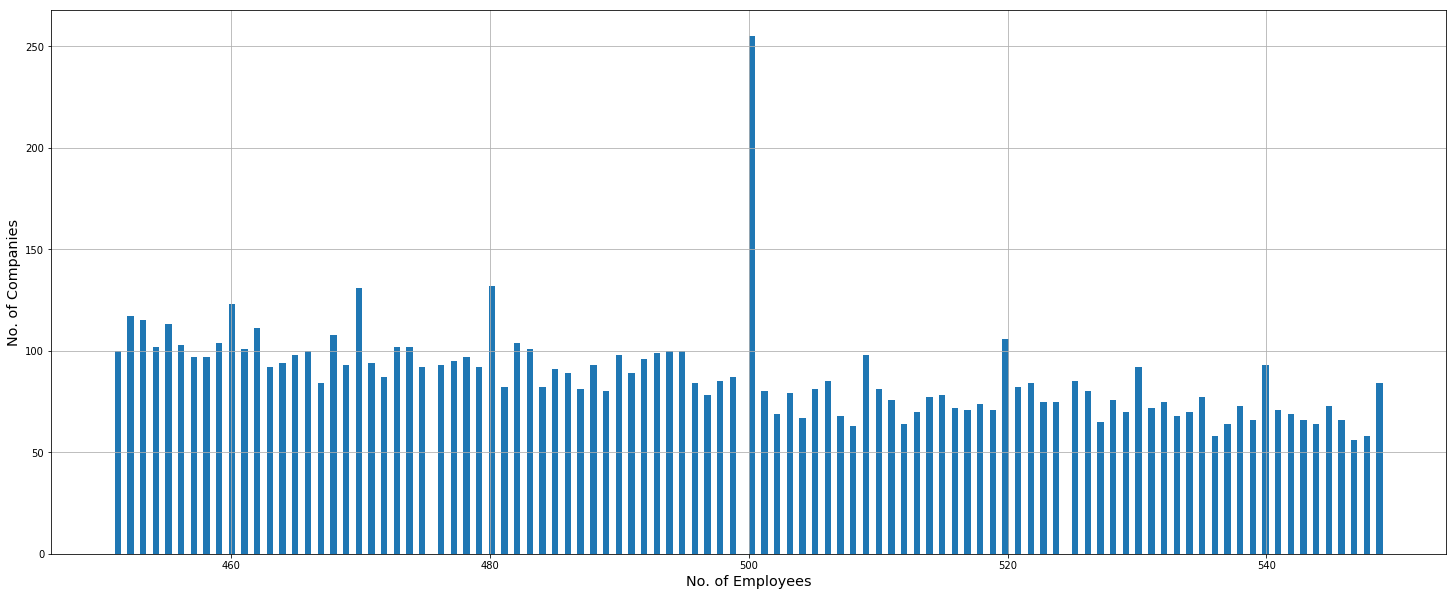

In [52]:
cond1 = (num_employees["Number of employees\nLast avail. yr"] == "n.a.")
cond2 = (num_employees["Number of employees\nLast avail. yr"] == "Credit needed")
cond3 = (num_employees["Number of employees\nLast avail. yr"]>450)
cond4 = (num_employees["Number of employees\nLast avail. yr"]<550)
cond5 = num_employees["Number of employees\nLast avail. yr"].isna()

num_employees = num_employees.loc[~cond1 & ~cond2]
num_employees["Number of employees\nLast avail. yr"] = num_employees["Number of employees\nLast avail. yr"].astype(int)
num_employees = num_employees.loc[cond3 & cond4]

num_employees["Number of employees\nLast avail. yr"].hist(bins=200, figsize = (25,10))
plt.xlabel("No. of Employees", size  = "x-large")
plt.ylabel("No. of Companies", size  = "x-large")

# Analysis of other Financial Variables

In [53]:
treatment_group = pd.read_excel("../data/Financial/treatment_group.xls", sheet_name = "Results")
control_group = pd.read_excel("../data/Financial/control_group.xls", sheet_name = "Results")

WARNING *** file size (2800805) not 512 + multiple of sector size (512)
WARNING *** file size (8274522) not 512 + multiple of sector size (512)


In [54]:
rnd_expenses_cols = [c for c in treatment_group.columns if "Research & Development expenses\nth EUR\n" in c and "Last" not in c]
rnd_expenses_by_or_cols = [c for c in treatment_group.columns if "R&D expenses / Operating revenue\n%\n" in c and "Last" not in c]
or_per_emp_cols = [c for c in treatment_group.columns if "Operating revenue per employee\nth EUR\n" in c and "Last" not in c]
pmargin_cols = [c for c in treatment_group.columns if "Profit margin\n%\n" in c and "Last" not in c]
category_cols = ["Total assets\nth EUR\nLast avail. yr","Country","Industry text"]

In [55]:
def prepare_dataset(columns, post_year = 2017, control_for = [], begin_year=2014):
    use_columns = columns + control_for
    
    tr = treatment_group[use_columns].fillna(0)
    tr.columns = [c[-4:] if c not in control_for else c for c in tr.columns]
    
    value_columns = [c for c in tr.columns if c not in control_for]
    tr_panel = pd.melt(tr, id_vars = control_for, value_vars=value_columns, var_name ="year", value_name = "Y")
    
    tr_panel["year"] = tr_panel["year"].astype(int)
    tr_panel = tr_panel.loc[tr_panel.year >=begin_year].reset_index(drop=True)
    
    tr_panel.loc[tr_panel.year >= post_year,"post_cutoff"] = 1
    tr_panel.loc[tr_panel.year < post_year,"post_cutoff"] = 0
    
    tr_panel = tr_panel.loc[((tr_panel.Y != "n.a.") & (tr_panel.Y != "n.s."))]
    tr_panel.Y = tr_panel.Y.astype(float)
    
    tr_panel["running_variable"] = tr_panel["year"] - post_year
    tr_panel["intercept"] = 1
    return tr_panel[["post_cutoff","running_variable","intercept", "Y", "year"] + control_for]

# Regression using R&D Spending

In [56]:
control_for = []

panel = prepare_dataset(rnd_expenses_cols, post_year = 2017, control_for = control_for )
panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= control_for, drop_first=True)
model = sm.OLS(panel[["Y"]], panel[["intercept","post_cutoff","running_variable"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.009213
Date:                Wed, 08 Apr 2020   Prob (F-statistic):              0.991
Time:                        14:56:57   Log-Likelihood:                -42523.
No. Observations:                2854   AIC:                         8.505e+04
Df Residuals:                    2851   BIC:                         8.507e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept         1.683e+05   3.96e+04      4.251      0.000    9.07e+04    2.46e+05
post_cutoff      -6061.3035   5.41e+04     -0.112      0.911   -1.12e+05    9.99e+04
running_variable  2412.3757   1.78e+04      0.135      0.892   -3.25e+04    3.73e+04
==============================================================================
Omnibus:                     3989.190   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           824794.977
Skew:                           8.234   Prob(JB):                         0.00
Kurtosis:                      84.638   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Regression using R&D Spending (Controlled for Country  & Total Assets)

In [57]:
control_for = ["Country"]

panel = prepare_dataset(rnd_expenses_cols, post_year = 2017, control_for = control_for )
panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= control_for, drop_first=True)

model = sm.OLS(panel[["Y"]], panel[["intercept","post_cutoff","running_variable"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     14.14
Date:                Wed, 08 Apr 2020   Prob (F-statistic):           4.80e-29
Time:                        14:56:59   Log-Likelihood:                -42440.
No. Observations:                2854   AIC:                         8.491e+04
Df Residuals:                    2841   BIC:                         8.498e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept          4.522e+04    1.5e+05      0.302      0.763   -2.48e+05    3.39e+05
post_cutoff        4320.2899   5.26e+04      0.082      0.935   -9.89e+04    1.08e+05
running_variable   9188.6442   1.74e+04      0.529      0.597   -2.49e+04    4.32e+04
d__Belgium         7.914e+04   1.66e+05      0.478      0.633   -2.46e+05    4.04e+05
d__Denmark         2.237e+05   1.69e+05      1.324      0.186   -1.08e+05    5.55e+05
d__France          5.565e+04   1.47e+05      0.380      0.704   -2.32e+05    3.43e+05
d__Germany          4.87e+05   1.51e+05      3.232      0.001    1.92e+05    7.82e+05
d__Ireland         6087.4934   1.99e+05      0.031      0.976   -3.85e+05    3.97e+05
d__Luxembourg      3.805e+04   2.31e+05      0.165      0.869   -4.15e+05    4.91e+05
d__Sweden          1.924e+05   1.57e+05      1.225      0.221   -1.16e+05       5e+05
d__Switzerland     4.507e+05   1.53e+05      2.943      0.003     1.5e+05    7.51e+05
d__Turkey         -3.506e+04   1.56e+05     -0.225      0.822   -3.41e+05    2.71e+05
d__United Kingdom  3884.3690   1.48e+05      0.026      0.979   -2.86e+05    2.94e+05
==============================================================================
Omnibus:                     3890.167   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           754294.769
Skew:                           7.862   Prob(JB):                         0.00
Kurtosis:                      81.076   Cond. No.                         70.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
control_for = ["Total assets\nth EUR\nLast avail. yr"]

panel = prepare_dataset(rnd_expenses_cols, post_year = 2017, control_for = control_for )
panel.loc[panel["Total assets\nth EUR\nLast avail. yr"]=="n.a.", "Total assets\nth EUR\nLast avail. yr"]=0
panel["Total assets\nth EUR\nLast avail. yr"] = panel["Total assets\nth EUR\nLast avail. yr"].astype(float)

model = sm.OLS(panel[["Y"]], panel[["intercept","post_cutoff","running_variable","Total assets\nth EUR\nLast avail. yr"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     336.5
Date:                Wed, 08 Apr 2020   Prob (F-statistic):          4.85e-187
Time:                        14:57:00   Log-Likelihood:                -42090.
No. Observations:                2854   AIC:                         8.419e+04
Df Residuals:                    2850   BIC:                         8.421e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                           2.986e+04   3.43e+04      0.870      0.384   -3.74e+04    9.71e+04
post_cutoff                        -1153.8299   4.65e+04     -0.025      0.980   -9.23e+04       9e+04
running_variable                    -362.3693   1.53e+04     -0.024      0.981   -3.04e+04    2.97e+04
Total assets
th EUR
Last avail. yr     0.0121      0.000     31.772      0.000       0.011       0.013
==============================================================================
Omnibus:                     3633.706   Durbin-Watson:                   2.325
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           850395.688
Skew:                           6.779   Prob(JB):                         0.00
Kurtosis:                      86.471   Cond. No.                     1.62e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
control_for = ["Total assets\nth EUR\nLast avail. yr","Country"]

panel = prepare_dataset(rnd_expenses_cols, post_year = 2017, control_for = control_for )
panel.loc[panel["Total assets\nth EUR\nLast avail. yr"]=="n.a.", "Total assets\nth EUR\nLast avail. yr"]=0
panel["Total assets\nth EUR\nLast avail. yr"] = panel["Total assets\nth EUR\nLast avail. yr"].astype(float)

panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= ["Country"], drop_first=True)

model = sm.OLS(panel[["Y"]], panel[["intercept","post_cutoff","running_variable","Total assets\nth EUR\nLast avail. yr"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     96.17
Date:                Wed, 08 Apr 2020   Prob (F-statistic):          1.22e-213
Time:                        14:57:02   Log-Likelihood:                -42002.
No. Observations:                2854   AIC:                         8.403e+04
Df Residuals:                    2840   BIC:                         8.412e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                          -6.916e+04   1.28e+05     -0.538      0.590   -3.21e+05    1.83e+05
post_cutoff                         6547.6272   4.52e+04      0.145      0.885    -8.2e+04    9.51e+04
running_variable                    6792.3833   1.49e+04      0.456      0.649   -2.24e+04     3.6e+04
Total assets
th EUR
Last avail. yr     0.0120      0.000     31.933      0.000       0.011       0.013
d__Belgium                          1.462e+05   1.42e+05      1.029      0.303   -1.32e+05    4.25e+05
d__Denmark                          2.962e+05   1.45e+05      2.043      0.041    1.19e+04     5.8e+05
d__France                           6237.7649   1.26e+05      0.050      0.960    -2.4e+05    2.53e+05
d__Germany                           3.79e+05   1.29e+05      2.930      0.003    1.25e+05    6.33e+05
d__Ireland                          5.048e+04   1.71e+05      0.295      0.768   -2.85e+05    3.86e+05
d__Luxembourg                        1.31e+05   1.98e+05      0.660      0.509   -2.58e+05     5.2e+05
d__Sweden                           2.354e+05   1.35e+05      1.747      0.081   -2.88e+04       5e+05
d__Switzerland                      4.156e+05   1.31e+05      3.163      0.002    1.58e+05    6.73e+05
d__Turkey                           5.715e+04   1.34e+05      0.427      0.670   -2.06e+05     3.2e+05
d__United Kingdom                   2.127e+04   1.27e+05      0.168      0.867   -2.28e+05     2.7e+05
==============================================================================
Omnibus:                     3582.142   Durbin-Watson:                   2.312
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           803926.974
Skew:                           6.611   Prob(JB):                         0.00
Kurtosis:                      84.152   Cond. No.                     1.20e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Regression using R&D Spending/Operating Revenue

In [60]:
control_for = []

panel = prepare_dataset(rnd_expenses_by_or_cols, post_year = 2017, control_for = control_for )
panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= control_for, drop_first=True)
model = sm.OLS(panel[["Y"]], panel[["intercept","post_cutoff","running_variable"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2100
Date:                Wed, 08 Apr 2020   Prob (F-statistic):              0.811
Time:                        14:57:04   Log-Likelihood:                -8832.1
No. Observations:                2852   AIC:                         1.767e+04
Df Residuals:                    2849   BIC:                         1.769e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            2.9651      0.296     10.004      0.000       2.384       3.546
post_cutoff          0.0225      0.405      0.056      0.956      -0.771       0.816
running_variable    -0.0498      0.133     -0.373      0.709      -0.311       0.212
==============================================================================
Omnibus:                     2714.797   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           206037.642
Skew:                           4.344   Prob(JB):                         0.00
Kurtosis:                      43.723   Cond. No.                         9.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Regression using R&D Spending/Operating Revenue (Controlled for Country  & Total Assets)

In [61]:
control_for = ["Country"]

panel = prepare_dataset(rnd_expenses_by_or_cols, post_year = 2017, control_for = control_for )
panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= control_for, drop_first=True)
model = sm.OLS(panel[["Y"]], panel[["intercept","post_cutoff","running_variable"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     46.04
Date:                Wed, 08 Apr 2020   Prob (F-statistic):          1.34e-100
Time:                        14:57:08   Log-Likelihood:                -8578.8
No. Observations:                2852   AIC:                         1.718e+04
Df Residuals:                    2839   BIC:                         1.726e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            10.7526      1.055     10.189      0.000       8.683      12.822
post_cutoff           0.0782      0.371      0.211      0.833      -0.650       0.806
running_variable     -0.0150      0.123     -0.122      0.903      -0.255       0.225
d__Belgium           -4.5452      1.167     -3.893      0.000      -6.834      -2.256
d__Denmark           -0.6885      1.191     -0.578      0.563      -3.025       1.648
d__France            -9.3517      1.033     -9.049      0.000     -11.378      -7.325
d__Germany           -5.0294      1.062     -4.734      0.000      -7.113      -2.946
d__Ireland           -9.9588      1.406     -7.085      0.000     -12.715      -7.203
d__Luxembourg        -6.1162      1.630     -3.752      0.000      -9.312      -2.920
d__Sweden            -5.5190      1.107     -4.983      0.000      -7.690      -3.347
d__Switzerland       -6.0629      1.080     -5.615      0.000      -8.180      -3.946
d__Turkey           -10.3819      1.101     -9.431      0.000     -12.540      -8.223
d__United Kingdom    -7.7877      1.043     -7.463      0.000      -9.834      -5.742
==============================================================================
Omnibus:                     2707.430   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           212605.412
Skew:                           4.309   Prob(JB):                         0.00
Kurtosis:                      44.410   Cond. No.                         70.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
control_for = ["Total assets\nth EUR\nLast avail. yr"]

panel = prepare_dataset(rnd_expenses_by_or_cols, post_year = 2017, control_for = control_for )
panel.loc[panel["Total assets\nth EUR\nLast avail. yr"]=="n.a.", "Total assets\nth EUR\nLast avail. yr"]=0
panel["Total assets\nth EUR\nLast avail. yr"] = panel["Total assets\nth EUR\nLast avail. yr"].astype(float)

model = sm.OLS(panel[["Y"]], panel[["intercept","post_cutoff","running_variable","Total assets\nth EUR\nLast avail. yr"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2890
Date:                Wed, 08 Apr 2020   Prob (F-statistic):              0.833
Time:                        14:57:10   Log-Likelihood:                -8831.9
No. Observations:                2852   AIC:                         1.767e+04
Df Residuals:                    2848   BIC:                         1.770e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                              2.9905      0.299     10.007      0.000       2.405       3.576
post_cutoff                            0.0216      0.405      0.053      0.957      -0.772       0.815
running_variable                      -0.0493      0.133     -0.370      0.712      -0.311       0.212
Total assets
th EUR
Last avail. yr -2.228e-09   3.33e-09     -0.669      0.504   -8.76e-09     4.3e-09
==============================================================================
Omnibus:                     2713.680   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           205678.428
Skew:                           4.341   Prob(JB):                         0.00
Kurtosis:                      43.687   Cond. No.                     1.62e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
control_for = ["Total assets\nth EUR\nLast avail. yr","Country"]

panel = prepare_dataset(rnd_expenses_cols, post_year = 2017, control_for = control_for )
panel.loc[panel["Total assets\nth EUR\nLast avail. yr"]=="n.a.", "Total assets\nth EUR\nLast avail. yr"]=0
panel["Total assets\nth EUR\nLast avail. yr"] = panel["Total assets\nth EUR\nLast avail. yr"].astype(float)

panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= ["Country"], drop_first=True)

model = sm.OLS(panel[["Y"]], panel[["intercept","post_cutoff","running_variable","Total assets\nth EUR\nLast avail. yr"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     96.17
Date:                Wed, 08 Apr 2020   Prob (F-statistic):          1.22e-213
Time:                        14:57:12   Log-Likelihood:                -42002.
No. Observations:                2854   AIC:                         8.403e+04
Df Residuals:                    2840   BIC:                         8.412e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                          -6.916e+04   1.28e+05     -0.538      0.590   -3.21e+05    1.83e+05
post_cutoff                         6547.6272   4.52e+04      0.145      0.885    -8.2e+04    9.51e+04
running_variable                    6792.3833   1.49e+04      0.456      0.649   -2.24e+04     3.6e+04
Total assets
th EUR
Last avail. yr     0.0120      0.000     31.933      0.000       0.011       0.013
d__Belgium                          1.462e+05   1.42e+05      1.029      0.303   -1.32e+05    4.25e+05
d__Denmark                          2.962e+05   1.45e+05      2.043      0.041    1.19e+04     5.8e+05
d__France                           6237.7649   1.26e+05      0.050      0.960    -2.4e+05    2.53e+05
d__Germany                           3.79e+05   1.29e+05      2.930      0.003    1.25e+05    6.33e+05
d__Ireland                          5.048e+04   1.71e+05      0.295      0.768   -2.85e+05    3.86e+05
d__Luxembourg                        1.31e+05   1.98e+05      0.660      0.509   -2.58e+05     5.2e+05
d__Sweden                           2.354e+05   1.35e+05      1.747      0.081   -2.88e+04       5e+05
d__Switzerland                      4.156e+05   1.31e+05      3.163      0.002    1.58e+05    6.73e+05
d__Turkey                           5.715e+04   1.34e+05      0.427      0.670   -2.06e+05     3.2e+05
d__United Kingdom                   2.127e+04   1.27e+05      0.168      0.867   -2.28e+05     2.7e+05
==============================================================================
Omnibus:                     3582.142   Durbin-Watson:                   2.312
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           803926.974
Skew:                           6.611   Prob(JB):                         0.00
Kurtosis:                      84.152   Cond. No.                     1.20e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Regression using Operating Revenue per Employee 

In [64]:
control_for = []

panel = prepare_dataset(or_per_emp_cols, post_year = 2017, control_for = control_for )
panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= control_for, drop_first=True)
model = sm.OLS(panel[["Y"]], panel[["intercept","post_cutoff","running_variable"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6009
Date:                Wed, 08 Apr 2020   Prob (F-statistic):              0.548
Time:                        14:57:16   Log-Likelihood:                -90564.
No. Observations:               11225   AIC:                         1.811e+05
Df Residuals:                   11222   BIC:                         1.812e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept          262.2419     21.922     11.962      0.000     219.270     305.213
post_cutoff         22.1693     29.478      0.752      0.452     -35.613      79.951
running_variable   -10.4266      9.916     -1.052      0.293     -29.863       9.010
==============================================================================
Omnibus:                    27258.720   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        469141711.788
Skew:                          25.267   Prob(JB):                         0.00
Kurtosis:                    1003.255   Cond. No.                         9.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Regression using Operating Revenue per Employee (Controlled for Country  & Total Assets)

In [65]:
control_for = ["Country"]

panel = prepare_dataset(or_per_emp_cols, post_year = 2017, control_for = control_for )
panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= control_for, drop_first=True)
model = sm.OLS(panel[["Y"]], panel[["intercept","post_cutoff","running_variable"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     6.398
Date:                Wed, 08 Apr 2020   Prob (F-statistic):           4.46e-32
Time:                        14:57:18   Log-Likelihood:                -90440.
No. Observations:               11225   AIC:                         1.810e+05
Df Residuals:                   11185   BIC:                         1.813e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                   246.6003     66.466      3.710      0.000     116.316     376.885
post_cutoff                  29.0204     29.251      0.992      0.321     -28.317      86.358
running_variable            -11.5736      9.846     -1.175      0.240     -30.874       7.727
d__Belgium                   76.5529     85.381      0.897      0.370     -90.810     243.916
d__Bosnia and Herzegovina  -216.3305    105.508     -2.050      0.040    -423.145      -9.516
d__Bulgaria                -171.3039    105.450     -1.624      0.104    -378.005      35.398
d__Croatia                 -167.4453     95.982     -1.745      0.081    -355.587      20.697
d__Czech Republic           139.0914    229.794      0.605      0.545    -311.344     589.527
d__Denmark                   44.4672     81.501      0.546      0.585    -115.290     204.224
d__Estonia                  566.5198    544.670      1.040      0.298    -501.130    1634.170
d__Finland                   60.2570     73.775      0.817      0.414     -84.355     204.869
d__France                    24.0675     66.800      0.360      0.719    -106.872     155.007
d__Germany                   59.0877     67.224      0.879      0.379     -72.683     190.858
d__Gibraltar                 64.4310    347.899      0.185      0.853    -617.513     746.375
d__Greece                   319.4942     97.466      3.278      0.001     128.444     510.545
d__Hungary                  -63.2896    132.665     -0.477      0.633    -323.336     196.757
d__Iceland                   13.7799    143.891      0.096      0.924    -268.272     295.832
d__Ireland                  173.7823     89.416      1.944      0.052      -1.489     349.054
d__Italy                    210.0882     72.026      2.917      0.004      68.905     351.271
d__Latvia                  -164.0924    165.509     -0.991      0.321    -488.520     160.335
d__Lithuania               -122.0845    132.639     -0.920      0.357    -382.080     137.911
d__Luxembourg               114.3702    162.794      0.703      0.482    -204.734     433.474
d__Montenegro              -183.2032    165.509     -1.107      0.268    -507.631     141.224
d__Netherlands              212.7798     80.600      2.640      0.008      54.791     370.769
d__North Macedonia         -206.4764    120.930     -1.707      0.088    -443.521      30.569
d__Norway                  1570.0199    277.745      5.653      0.000    1025.591    2114.449
d__Poland                   -91.8747     72.719     -1.263      0.206    -234.416      50.666
d__Portugal                 576.5984    207.365      2.781      0.005     170.127     983.070
d__Republic of Moldova     -231.5890    142.314     -1.627      0.104    -510.549      47.371
d__Romania                 -120.9378     85.940     -1.407      0.159    -2

In [66]:
control_for = ["Total assets\nth EUR\nLast avail. yr"]

panel = prepare_dataset(or_per_emp_cols, post_year = 2017, control_for = control_for )
panel.loc[panel["Total assets\nth EUR\nLast avail. yr"]=="n.a.", "Total assets\nth EUR\nLast avail. yr"]=0
panel["Total assets\nth EUR\nLast avail. yr"] = panel["Total assets\nth EUR\nLast avail. yr"].astype(float)

model = sm.OLS(panel[["Y"]], panel[["intercept","post_cutoff","running_variable","Total assets\nth EUR\nLast avail. yr"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     82.00
Date:                Wed, 08 Apr 2020   Prob (F-statistic):           1.80e-52
Time:                        14:57:21   Log-Likelihood:                -90443.
No. Observations:               11225   AIC:                         1.809e+05
Df Residuals:                   11221   BIC:                         1.809e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                            238.6102     21.741     10.975      0.000     195.995     281.225
post_cutoff                           22.2692     29.163      0.764      0.445     -34.895      79.433
running_variable                     -10.7696      9.810     -1.098      0.272     -29.999       8.460
Total assets
th EUR
Last avail. yr  3.687e-06   2.36e-07     15.645      0.000    3.23e-06    4.15e-06
==============================================================================
Omnibus:                    27410.018   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        501396747.438
Skew:                          25.599   Prob(JB):                         0.00
Kurtosis:                    1037.122   Cond. No.                     1.59e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
control_for = ["Total assets\nth EUR\nLast avail. yr","Country"]

panel = prepare_dataset(rnd_expenses_cols, post_year = 2017, control_for = control_for )
panel.loc[panel["Total assets\nth EUR\nLast avail. yr"]=="n.a.", "Total assets\nth EUR\nLast avail. yr"]=0
panel["Total assets\nth EUR\nLast avail. yr"] = panel["Total assets\nth EUR\nLast avail. yr"].astype(float)

panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= ["Country"], drop_first=True)

model = sm.OLS(panel[["Y"]], panel[["intercept","post_cutoff","running_variable","Total assets\nth EUR\nLast avail. yr"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     96.17
Date:                Wed, 08 Apr 2020   Prob (F-statistic):          1.22e-213
Time:                        14:57:23   Log-Likelihood:                -42002.
No. Observations:                2854   AIC:                         8.403e+04
Df Residuals:                    2840   BIC:                         8.412e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                          -6.916e+04   1.28e+05     -0.538      0.590   -3.21e+05    1.83e+05
post_cutoff                         6547.6272   4.52e+04      0.145      0.885    -8.2e+04    9.51e+04
running_variable                    6792.3833   1.49e+04      0.456      0.649   -2.24e+04     3.6e+04
Total assets
th EUR
Last avail. yr     0.0120      0.000     31.933      0.000       0.011       0.013
d__Belgium                          1.462e+05   1.42e+05      1.029      0.303   -1.32e+05    4.25e+05
d__Denmark                          2.962e+05   1.45e+05      2.043      0.041    1.19e+04     5.8e+05
d__France                           6237.7649   1.26e+05      0.050      0.960    -2.4e+05    2.53e+05
d__Germany                           3.79e+05   1.29e+05      2.930      0.003    1.25e+05    6.33e+05
d__Ireland                          5.048e+04   1.71e+05      0.295      0.768   -2.85e+05    3.86e+05
d__Luxembourg                        1.31e+05   1.98e+05      0.660      0.509   -2.58e+05     5.2e+05
d__Sweden                           2.354e+05   1.35e+05      1.747      0.081   -2.88e+04       5e+05
d__Switzerland                      4.156e+05   1.31e+05      3.163      0.002    1.58e+05    6.73e+05
d__Turkey                           5.715e+04   1.34e+05      0.427      0.670   -2.06e+05     3.2e+05
d__United Kingdom                   2.127e+04   1.27e+05      0.168      0.867   -2.28e+05     2.7e+05
==============================================================================
Omnibus:                     3582.142   Durbin-Watson:                   2.312
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           803926.974
Skew:                           6.611   Prob(JB):                         0.00
Kurtosis:                      84.152   Cond. No.                     1.20e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Regression using Profit Margin

In [68]:
control_for = []

panel = prepare_dataset(pmargin_cols, post_year = 2017, control_for = control_for )
panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= control_for, drop_first=True)
model = sm.OLS(panel[["Y"]], panel[["intercept","post_cutoff","running_variable"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.149
Date:                Wed, 08 Apr 2020   Prob (F-statistic):            0.00582
Time:                        14:57:26   Log-Likelihood:                -50131.
No. Observations:               12267   AIC:                         1.003e+05
Df Residuals:                   12264   BIC:                         1.003e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            6.7087      0.392     17.108      0.000       5.940       7.477
post_cutoff          0.5234      0.527      0.993      0.321      -0.509       1.556
running_variable     0.1196      0.177      0.674      0.500      -0.228       0.467
==============================================================================
Omnibus:                     2545.384   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            62375.586
Skew:                          -0.388   Prob(JB):                         0.00
Kurtosis:                      14.020   Cond. No.                         9.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Regression using Profit Margin (Controlled for Country & Total Assets)

In [69]:
control_for = ["Country"]

panel = prepare_dataset(pmargin_cols, post_year = 2017, control_for = control_for )
panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= control_for, drop_first=True)
model = sm.OLS(panel[["Y"]], panel[["intercept","post_cutoff","running_variable"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     11.44
Date:                Wed, 08 Apr 2020   Prob (F-statistic):           4.42e-69
Time:                        14:57:29   Log-Likelihood:                -49916.
No. Observations:               12267   AIC:                         9.991e+04
Df Residuals:                   12227   BIC:                         1.002e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                     6.6032      1.166      5.661      0.000       4.317       8.890
post_cutoff                   0.5376      0.519      1.036      0.300      -0.480       1.555
running_variable              0.0916      0.175      0.524      0.600      -0.251       0.434
d__Belgium                    0.5493      1.457      0.377      0.706      -2.307       3.406
d__Bosnia and Herzegovina    -5.6555      1.919     -2.948      0.003      -9.416      -1.895
d__Bulgaria                  -0.7447      1.926     -0.387      0.699      -4.520       3.030
d__Croatia                   -4.7022      1.743     -2.698      0.007      -8.119      -1.285
d__Czech Republic             7.6772      3.437      2.234      0.026       0.941      14.413
d__Denmark                    4.1181      1.453      2.834      0.005       1.269       6.967
d__Estonia                   11.1640      6.438      1.734      0.083      -1.455      23.783
d__Finland                   -1.2719      1.315     -0.967      0.333      -3.849       1.305
d__France                    -0.2200      1.178     -0.187      0.852      -2.529       2.089
d__Germany                    0.5128      1.188      0.432      0.666      -1.815       2.841
d__Gibraltar                  4.6554      6.438      0.723      0.470      -7.963      17.274
d__Greece                    -2.5390      1.550     -1.638      0.101      -5.577       0.499
d__Hungary                   -0.1004      2.408     -0.042      0.967      -4.820       4.619
d__Iceland                    2.1936      2.610      0.840      0.401      -2.922       7.309
d__Ireland                   -4.8948      1.614     -3.033      0.002      -8.058      -1.732
d__Italy                     -1.3223      1.280     -1.033      0.302      -3.831       1.187
d__Latvia                    -3.8416      3.045     -1.262      0.207      -9.809       2.126
d__Lithuania                 -1.3386      2.429     -0.551      0.582      -6.101       3.424
d__Luxembourg                -0.5388      2.501     -0.215      0.829      -5.440       4.363
d__Montenegro                -2.6874      3.045     -0.883      0.377      -8.655       3.280
d__Netherlands                0.9541      1.422      0.671      0.502      -1.833       3.741
d__North Macedonia           -4.8725      2.225     -2.190      0.029      -9.234      -0.511
d__Norway                    -0.5794      1.314     -0.441      0.659      -3.155       1.996
d__Poland                    -2.1023      1.228     -1.711      0.087      -4.510       0.306
d__Portugal                   7.3405      3.825      1.919      0.055      -0.157      14.838
d__Republic of Moldova        0.4999      3.100      0.161      0.872      -5.577       6.576
d__Romania                   -2.7059      1.552     -1.743      0.081      

In [70]:
control_for = ["Total assets\nth EUR\nLast avail. yr"]

panel = prepare_dataset(pmargin_cols, post_year = 2017, control_for = control_for )
panel.loc[panel["Total assets\nth EUR\nLast avail. yr"]=="n.a.", "Total assets\nth EUR\nLast avail. yr"]=0
panel["Total assets\nth EUR\nLast avail. yr"] = panel["Total assets\nth EUR\nLast avail. yr"].astype(float)

model = sm.OLS(panel[["Y"]], panel[["intercept","post_cutoff","running_variable","Total assets\nth EUR\nLast avail. yr"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     14.69
Date:                Wed, 08 Apr 2020   Prob (F-statistic):           1.50e-09
Time:                        14:57:32   Log-Likelihood:                -50114.
No. Observations:               12267   AIC:                         1.002e+05
Df Residuals:                   12263   BIC:                         1.003e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                              6.5461      0.393     16.674      0.000       5.777       7.316
post_cutoff                            0.5329      0.526      1.013      0.311      -0.499       1.564
running_variable                       0.1144      0.177      0.646      0.518      -0.233       0.462
Total assets
th EUR
Last avail. yr  2.569e-08   4.42e-09      5.810      0.000     1.7e-08    3.44e-08
==============================================================================
Omnibus:                     2547.094   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            62570.617
Skew:                          -0.388   Prob(JB):                         0.00
Kurtosis:                      14.037   Cond. No.                     1.53e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
control_for = ["Total assets\nth EUR\nLast avail. yr","Country"]

panel = prepare_dataset(rnd_expenses_cols, post_year = 2017, control_for = control_for )
panel.loc[panel["Total assets\nth EUR\nLast avail. yr"]=="n.a.", "Total assets\nth EUR\nLast avail. yr"]=0
panel["Total assets\nth EUR\nLast avail. yr"] = panel["Total assets\nth EUR\nLast avail. yr"].astype(float)

panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= ["Country"], drop_first=True)

model = sm.OLS(panel[["Y"]], panel[["intercept","post_cutoff","running_variable","Total assets\nth EUR\nLast avail. yr"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     96.17
Date:                Wed, 08 Apr 2020   Prob (F-statistic):          1.22e-213
Time:                        14:57:34   Log-Likelihood:                -42002.
No. Observations:                2854   AIC:                         8.403e+04
Df Residuals:                    2840   BIC:                         8.412e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                          -6.916e+04   1.28e+05     -0.538      0.590   -3.21e+05    1.83e+05
post_cutoff                         6547.6272   4.52e+04      0.145      0.885    -8.2e+04    9.51e+04
running_variable                    6792.3833   1.49e+04      0.456      0.649   -2.24e+04     3.6e+04
Total assets
th EUR
Last avail. yr     0.0120      0.000     31.933      0.000       0.011       0.013
d__Belgium                          1.462e+05   1.42e+05      1.029      0.303   -1.32e+05    4.25e+05
d__Denmark                          2.962e+05   1.45e+05      2.043      0.041    1.19e+04     5.8e+05
d__France                           6237.7649   1.26e+05      0.050      0.960    -2.4e+05    2.53e+05
d__Germany                           3.79e+05   1.29e+05      2.930      0.003    1.25e+05    6.33e+05
d__Ireland                          5.048e+04   1.71e+05      0.295      0.768   -2.85e+05    3.86e+05
d__Luxembourg                        1.31e+05   1.98e+05      0.660      0.509   -2.58e+05     5.2e+05
d__Sweden                           2.354e+05   1.35e+05      1.747      0.081   -2.88e+04       5e+05
d__Switzerland                      4.156e+05   1.31e+05      3.163      0.002    1.58e+05    6.73e+05
d__Turkey                           5.715e+04   1.34e+05      0.427      0.670   -2.06e+05     3.2e+05
d__United Kingdom                   2.127e+04   1.27e+05      0.168      0.867   -2.28e+05     2.7e+05
==============================================================================
Omnibus:                     3582.142   Durbin-Watson:                   2.312
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           803926.974
Skew:                           6.611   Prob(JB):                         0.00
Kurtosis:                      84.152   Cond. No.                     1.20e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""